# Использование предобученных моделей

Задание: собрать датасет и использовать перенос обучения для решения задачи классификации.

## Порядок выполнения

1. Скачать изображения для создания датасета. Как структурировать папки подсмотрите в работе по ConvNet в датасете с Симпсонами;
1. Подготовить transforms, DataSet и DataLoader;
1. Выбрать одну из моделей в библиотеке timm;
1. Использовать на этой модели прием выделения признаков;
1. Использовать на этой модели прием дообучения (fine-tune);
1. Оценить результаты лучшей модели на тестовой выборке.

## Источники

1. [Туториал от Pytorch](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
1. [GitHub pytorch-image-models](https://github.com/huggingface/pytorch-image-models)
1. [Извлечение признаков](https://huggingface.co/docs/timm/feature_extraction)
1. [Which image models are best?](https://www.kaggle.com/code/jhoward/which-image-models-are-best)
1. [Pytorch Image Models (timm)](https://timm.fast.ai/)
1. [huggingface docs timm](https://huggingface.co/docs/hub/timm)

## Создание датасета

В этом задании вам надо собрать собственный датасет из изображений. В нем должно быть минимум 30 изображений для каждого класса. Количество классов не менее 2. Тематику датасета вы выбираете самостоятельно.

Далее в этом разделе приведен пример кода, который помогает скачать изображения по запросу на гугл диск. Вы можете решить эту задачу другими удобными для вас способами, в том числе и вручную.

Если вы работаете с локальной средой, то код из примера придется модифицировать.

In [ ]:
# Установка пакета для работы с API поисковика DuckDuckGo

!pip install -U duckduckgo_search

In [2]:
from duckduckgo_search import DDGS  # импотр модуля

animals_list = ['dog', 'cat', 'horse', 'bear', 'wolf', 'rabbit', 'cow', 'pig', 'zebra', 'lion']

for animal in animals_list:
    with DDGS() as ddgs:
        ddgs_images_gen = ddgs.images(
        f'{animal} photo',
        region="wt-wt",
        size="Medium",
        type_image="photo",
        max_results=1000,  # максимальное количество изображений в ответе
        )
        with open(f'animal_data/{animal}.txt', 'w', encoding='utf-8') as f:  # пишем в файл полученные ссылки на изображения для скачивания
            for r in ddgs_images_gen:
                f.write(f"{r['image']}\n")

In [ ]:
# монтируем гугл диск к среде, чтобы можно было записывать и считывать изображения
# в постоянное хранилище на гугл диске. Колаб попросит предоставить доступ.

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# пример создания папки dataset в корне вашего гугл диска
!mkdir "/content/drive/My Drive/dataset"

In [ ]:
# можно посмотреть содержимое файла со ссылками
!cat owl.txt

In [3]:
# утилита wget построчно читает файл owl.txt и скачивает по URL файлы в папку,
# указанную после флага -P. --random-wait добавляет случайные интервалы между запросами,
# чтобы снизить вероятность блокировки
import os
import requests

# Папка, куда будут сохраняться изображения
output_dir = "./animal_data/dataset"

# Убедитесь, что папка существует
os.makedirs(output_dir, exist_ok=True)

# Цикл по всем файлам из списка
for animal in animals_list:
    target_folder = os.path.join(output_dir, animal)  # Папка для конкретного животного
    os.makedirs(target_folder, exist_ok=True)  # Создаём папку, если её нет

    # Открываем файл с ссылками
    with open(f'animal_data/{animal}.txt', "r") as file:
        links = file.readlines()  # Читаем все строки (ссылки)

    # Цикл по каждой ссылке
    for i, link in enumerate(links, start=1):
        link = link.strip()  # Удаляем лишние пробелы и символы перевода строки
        if not link:
            continue  # Пропускаем пустые строки

        try:
            # Загружаем изображение
            response = requests.get(link, stream=True, timeout=10)  # Stream=True для больших файлов
            response.raise_for_status()  # Проверяем на ошибки HTTP

            # Определяем имя файла
            filename = os.path.join(target_folder, f"image_{i}.jpg")

            # Сохраняем файл
            with open(filename, "wb") as img_file:
                for chunk in response.iter_content(chunk_size=8192):  # Сохраняем по частям
                    img_file.write(chunk)

            print(f"Скачано: {filename}")
        except requests.exceptions.RequestException as e:
            print(f"Ошибка при загрузке {link}: {e}")

Скачано: ./animal_data/dataset\dog\image_1.jpg
Ошибка при загрузке http://www.publicdomainpictures.net/pictures/40000/velka/rough-collie-dog-1361732766Q2h.jpg: 403 Client Error: Forbidden for url: http://www.publicdomainpictures.net/pictures/40000/velka/rough-collie-dog-1361732766Q2h.jpg
Скачано: ./animal_data/dataset\dog\image_3.jpg
Скачано: ./animal_data/dataset\dog\image_4.jpg
Ошибка при загрузке https://img.dog-learn.com/dog-breeds/pomeranian/pomeranian-sz6.jpg: HTTPSConnectionPool(host='img.dog-learn.com', port=443): Max retries exceeded with url: /dog-breeds/pomeranian/pomeranian-sz6.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:992)')))
Скачано: ./animal_data/dataset\dog\image_6.jpg
Скачано: ./animal_data/dataset\dog\image_7.jpg
Скачано: ./animal_data/dataset\dog\image_8.jpg
Ошибка при загрузке https://picfiles.alphacoders.com/288/288986.jpg: 403 Client Error: Forbidden for url: ht

### Ответы по датасету (макс. 20 баллов)

В результате работы по этому разделу у вас должен получиться датасет. Проверьте что все скачанные изображения открываются и удалите поврежденные файлы. Изображения стоит разделить в папках на train и test и примерном соотношении 80 и 20%.

Доступ к вашему датасету потребуется открыть. Если вы скачивали изображения локально, то их надо будет выгрузить на гугл или яндекс диск.

**Ссылка на ваш датасет - https://drive.google.com/file/d/159Ics3wfJcd-7D2YRKuJIyCEcyj78F1r/view?usp=drive_link**

**Описание вашего датасета:**

* Общее описание решаемой задачи: классификация животных
* Количество классов: 10
* Имена классов: dog, cat, horse, bear, wolf, rabbit, cow, pig, zebra, lion
* Количество изображений в каждом классе в обучающей и тестовой выборках:
- dog (train - 128, test - 32)
- cat (train - 115, test - 29)
- horse (train - 92, test - 23)
- bear (train - 102, test - 25)
- wolf (train - 133, test - 33)
- rabbit (train - 134, test - 34)
- cow (train - 96, test - 24)
- pig (train - 62, test - 16)
- zebra (train - 96, text - 24)
- lion (train - 103, text - 26)

## Импортирование модулей

In [1]:
# по необходимости добавляйте свои модули

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Использование GPU по желанию

if torch.cuda.is_available():
  device = torch.device('cuda')
  print('Работаем на GPU')
else:
  device = torch.device('cpu')
  print('Работаем на CPU')

# Не забывайте про .to(device)

Работаем на CPU


## Выбор модели из timm

В источниках к заданию, вы найдете список моделей, который выложен на github и [сравнение части моделей из timm](https://www.kaggle.com/code/jhoward/which-image-models-are-best). Вам необходимо остановить свой выбор на одной из них. В списке моделей на github есть ссылки на статьи о них, где можно найти информацию на каком датасете они были обучены.

Если вы работаете с фотографиями выбор можно остановить на одной из:
1. MobileNet,
1. VGG,
1. ResNet,
1. Xception.

По желанию можете попробовать несколько и сравнить.


In [ ]:
# сначала требуется установить сам модуль timm
!pip install timm

In [3]:
import timm

c:\Users\Arina\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# вывод списка моделей содержащих *resnet* и предобученных
timm.list_models("*resnet*", pretrained=True)

In [47]:
# в качестве первого аргумента укажите имя выбранной модели
# и не забудьте указать, предобученный вариант (pretrained)
pretrained_model = timm.create_model('resnet50.a1_in1k', pretrained=True)

In [25]:
# Вывод архитектуры модели
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

В описании архитектуры модели в выводе предыдущей ячейки, найдите два новых модуля (Conv2d, ReLU вы уже знаете) и добавьте их описание. (макс. 15 баллов)

**Ваш ответ:**

1. Модуль BatchNorm2d - нормализует данные в двумерных тензорах (изображениях или на стадии активации в сверточных нейронных сетях)
1. Модуль MaxPool2d - снижает размерность входных данных с выделением более важных признаков, что помогает не учитывать незначительные искажения в изображении.

**Почему решили выбрать именно эту модель?** (макс. 5 баллов)

Ваш ответ: модели ResNet показывают высокую точность с разнообразными изображениями благодаря использованию остановочных соединений, что решает проблему затухающих градиентов при прохождении через слои. Таким образом модель можно делать более глубокой без потери точности. Также модель извлекает большое число признаков, благодаря чему предсказание становится более точным.

## Создание Dataset и DataLoader

По аналогии с прошлыми заданиями нам требуется создать transforms, которые передаются в создаваемый Dataset и из датасета вы создаете DataLoaders.

Данных у нас немного, поэтому мы не будем выделять валидационную часть.

При создании transforms помните, что модель ожидает на вход тензор определенной размерности. В [описание моделей](https://paperswithcode.com/lib/timm), вы можете найти датасет, на котором обучалась модель и есть описание размера изображений.

Для работы вам пригодится:

- v2.ToImage()
- v2.Resize() или v2.RandomResizedCrop() - размер изображения после кадрирования, должен быть равен размеру ожидаемому на ходе предобученной модели.
- v2.RandomRotation()
- v2.RandomHorizontalFlip()
- v2.ToDtype()

[Описания в документации](https://pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended)

In [26]:
transforms_stats = v2.Compose([
    torchvision.transforms.RandomResizedCrop(224),  # Случайное кадрирование до 224x224
    torchvision.transforms.RandomHorizontalFlip(), # Случайное горизонтальное отражение
	torchvision.transforms.ToTensor()             # Преобразование изображения в тензор
])

stats_dataset = ImageFolder(root="./animal_data/animal_dataset/train", transform=transforms_stats)

In [27]:
imgs = [item[0] for item in stats_dataset]
imgs = torch.stack(imgs, dim=0).numpy()

mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
print(f"Means R, G, B: {mean_r,mean_g,mean_b}")

std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
print(f"Std R, G, B: {std_r,std_g,std_b}")

c:\Users\Arina\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Means R, G, B: (0.51376987, 0.4835438, 0.41760033)
Std R, G, B: (0.2706335, 0.26508, 0.2751607)


In [28]:
transforms_train = v2.Compose([
    torchvision.transforms.RandomResizedCrop(224),  # Случайное кадрирование до 224x224
    torchvision.transforms.RandomHorizontalFlip(), # Случайное горизонтальное отражение
	torchvision.transforms.ToTensor(),             # Преобразование изображения в тензор
	v2.Normalize(mean=[mean_r,mean_g,mean_b], std=[std_r,std_g,std_b]) # Нормализация с вычисленными средними и отклонениями
])

transforms_test = v2.Compose([
    torchvision.transforms.RandomResizedCrop(224),  # Случайное кадрирование до 224x224
    torchvision.transforms.RandomHorizontalFlip(), # Случайное горизонтальное отражение
	torchvision.transforms.ToTensor(),             # Преобразование изображения в тензор
	v2.Normalize(mean=[mean_r,mean_g,mean_b], std=[std_r,std_g,std_b]) # Нормализация с вычисленными средними и отклонениями
])

In [29]:
train_dataset = ImageFolder(
	root='./animal_data/animal_dataset/train',
	transform=transforms_train
)

test_dataset = ImageFolder(
	root='./animal_data/animal_dataset/test',
	transform=transforms_test
)

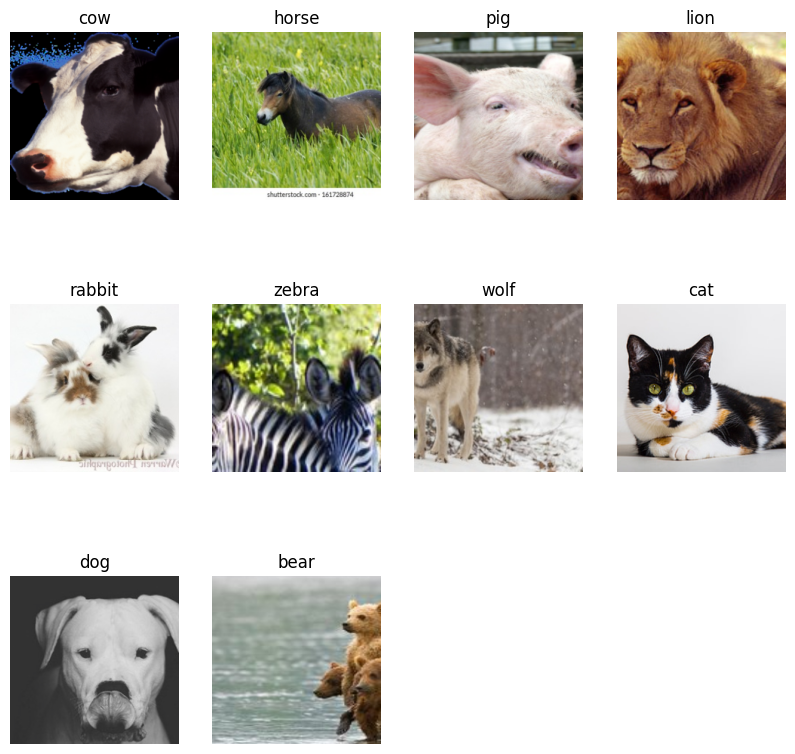

In [38]:
mean = [mean_r,mean_g,mean_b]
std = [std_r,std_g,std_b]
draw_label = []

labels_map = dict(zip(range(len(train_dataset.classes)), train_dataset.classes))
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 3
for i in range(1, 11):
	flag = 0
	while flag == 0:
		sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
		img, label = train_dataset[sample_idx]
		if label not in (draw_label):
			draw_label.append(label)
			flag = 1

	# Денормализация
	img = img.clone()
	for channel in range(3):
		img[channel] = img[channel] * std[channel] + mean[channel]

	# Переводим изображение в формат (H, W, C) для корректного отображения
	img = img.permute(1, 2, 0).numpy()

	figure.add_subplot(rows, cols, i)
	plt.title(labels_map[label])
	plt.axis("off")
	plt.imshow(img)
plt.show()

In [44]:
BATCH_SIZE = 32

train_loader = DataLoader(
	train_dataset,
	batch_size=BATCH_SIZE,
	shuffle=True
)

test_loader = DataLoader(
	test_dataset,
	batch_size=BATCH_SIZE,
	shuffle=False
)

**Почему выбрали именно такие преобразования (transforms) для данных?** (макс. 10 баллов)

Ваш ответ:
- RandomResizedCrop(224): Для обучения случайно кадрирует изображение до 224×224. Это помогает улучшить обобщающую способность модели.
- RandomHorizontalFlip(): Добавляет случайное горизонтальное отражение с вероятностью 50% для увеличения разнообразия данных.
- ToTensor(): Конвертирует изображение в тензор с каналами [C, H, W], данные в таком формате модель требует на вход.
- Normalize(mean, std): Применяет нормализацию для согласования входных данных с предположениями модели. Также согласует обучающую и тестовую выборки.

## Прием извлечения признаков

Этот прием может использоваться как сам по себе, так и быть предварительным этапом для дообучения.

Он заключается в том, что мы заменяем полносвязную часть модели (head/голову) на свою с учетом размерностей выходных данных из сверточной части и количеством классов в текущей задаче. Перед обучением требуется "заморозить" параметры сверточных слоев.

**Почему требуется "заморозка" параметров?** (макс. 10 баллов)

Ваш ответ:
1. Сохранение признаков изображений, которые предобученная модель уже "знает". Дообучение модели не повлияет на качество извлечения этих признаков.
2. При заморозке градиенты для сверточных слоев не вычисляются, что повышает скорость обучения модели.
3. При небольшом наборе данных для дообучения параметры сверточных сетей могут сильно исказится, из-за чего модель потеряет в качестве.



У модели вы можете использовать метод .parameters(), он возвращает итерируемый объект с параметрами вашей модели. Вы можете их перебрать и отключить необходимость расчета градиентов.

In [48]:
# "Замораживаем" веса
for param in pretrained_model.parameters():
    param.requires_grad = False

num_classes = 10  # Количество классов в задаче

# Заменяем "голову"
# .fc для вашей модели может иметь другое имя
# В nn.Sequential добавьте 1-2 скрытых слоя (nn.Linear, nn.ReLU)
pretrained_model.fc = nn.Sequential(
    nn.Linear(pretrained_model.fc.in_features, 256),  # Промежуточный слой
    nn.ReLU(),                                       # Активация
    nn.Dropout(0.3),                                 # Dropout для регуляризации
    nn.Linear(256, num_classes)                     # Выходной слой
)

In [49]:
loss_fn = nn.CrossEntropyLoss() # Определяем функцию потерь
optimizer = torch.optim.Adam(pretrained_model.fc.parameters(), lr=0.001) # Определяем оптимизатор

В этой работе также рассмотрим применение планировщика для изменения скорости обучения. Ранее у вас скорость обучения была константой, теперь же в процессе обучения каждые n эпох будем ее снижать.



In [50]:
from torch.optim import lr_scheduler

scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

### Обучение и тестирование

Несколько эпох обучите модель в таком состоянии. Для обучения используйте уже знакомый вам цикл с эпохами и перебором dataloader, но к нему в цикл эпох требуется добавить шаг планировщика scheduler.step().

Не забывайте переключать режимы моделей (pretrained_model.train(), pretrained_model.eval()), так как теперь в них может быть пакетная нормализация и используйте контекст torch.no_grad() при проверке модели.

In [51]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(num_epochs):
    # Переключаем модель в режим обучения
    pretrained_model.train()

    # Обучение
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        # Перенос данных на устройство
        images, labels = images.to(device), labels.to(device)

        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход
        outputs = pretrained_model(images)
        loss = loss_fn(outputs, labels)

        # Обратное распространение
        loss.backward()

        # Шаг оптимизации
        optimizer.step()

        # Накопление метрик
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    # Вычисление средней потери и точности для обучения
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Переключаем модель в режим оценки
    pretrained_model.eval()

    # Тестирование
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            # Перенос данных на устройство
            images, labels = images.to(device), labels.to(device)

            # Прямой проход
            outputs = pretrained_model(images)
            loss = loss_fn(outputs, labels)

            # Накопление метрик
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)

    # Вычисление средней потери и точности для теста
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct_test / total_test

    # Шаг планировщика
    scheduler.step()

    # Вывод метрик за эпоху
    print(
        f"Epoch {epoch + 1}/{num_epochs}: "
        f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
        f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}"
    )

Epoch 1/10: Train Loss: 1.8448, Train Accuracy: 0.5099, Test Loss: 1.2682, Test Accuracy: 0.8346
Epoch 2/10: Train Loss: 1.0117, Train Accuracy: 0.7795, Test Loss: 0.6510, Test Accuracy: 0.8872
Epoch 3/10: Train Loss: 0.6854, Train Accuracy: 0.8351, Test Loss: 0.5013, Test Accuracy: 0.8872
Epoch 4/10: Train Loss: 0.6028, Train Accuracy: 0.8454, Test Loss: 0.4542, Test Accuracy: 0.8872
Epoch 5/10: Train Loss: 0.5014, Train Accuracy: 0.8709, Test Loss: 0.3902, Test Accuracy: 0.8947
Epoch 6/10: Train Loss: 0.4799, Train Accuracy: 0.8690, Test Loss: 0.4111, Test Accuracy: 0.9060
Epoch 7/10: Train Loss: 0.4904, Train Accuracy: 0.8850, Test Loss: 0.3707, Test Accuracy: 0.9135
Epoch 8/10: Train Loss: 0.4953, Train Accuracy: 0.8662, Test Loss: 0.3754, Test Accuracy: 0.9023
Epoch 9/10: Train Loss: 0.4285, Train Accuracy: 0.9029, Test Loss: 0.3570, Test Accuracy: 0.9098
Epoch 10/10: Train Loss: 0.4609, Train Accuracy: 0.8737, Test Loss: 0.3358, Test Accuracy: 0.9060


## Прием дообучения

Чтобы дообучить модель, требуется разморозить параметры модели. Для упрощения можете разморозить все параметры модели, но более правильно будет разморозить параметры 1-2 последних слоев и оптимизировать их, и наиболее сложный вариант разморозить больше 2 слоев, но использовать сниженные скорости обучения для более ранних слоев модели - [TORCH.OPTIM](https://pytorch.org/docs/stable/optim.html#per-parameter-options).

In [53]:
# Первый вариант
# for param in ___:
    #param...

# Второй вариант
n = 2
for param in pretrained_model.layer4[-n:].parameters():
    param.requires_grad = True

# Третий вариант
# model.blocks[-n:].requires_grad_(True)
# optim.SGD([
#                 {'params': model.base.parameters()},
#                 {'params': model.classifier.parameters(), 'lr': 1e-3}
#             ], lr=1e-2, momentum=0.9)

In [54]:
# Новый набор объектов

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([
    {'params': pretrained_model.layer4.parameters(), 'lr': 1e-4},  # Размороженные параметры layer4
    {'params': pretrained_model.fc.parameters(), 'lr': 1e-3},     # Размороженные параметры fc
], lr=1e-2, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.3)

In [55]:
# Новый цикл обучения

for epoch in range(num_epochs):
    # Переводим модель в режим обучения
    pretrained_model.train()

    # Обучение
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        # Перенос данных на устройство
        images, labels = images.to(device), labels.to(device)

        # Обнуление градиентов
        optimizer.zero_grad()

        # Прямой проход
        outputs = pretrained_model(images)

        # Вычисление потерь
        loss = loss_fn(outputs, labels)

        # Обратное распространение ошибки
        loss.backward()

        # Шаг оптимизации
        optimizer.step()

        # Накопление метрик
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    # Вычисление средней потери и точности для обучения
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Тестирование
    pretrained_model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = pretrained_model(images)
            loss = loss_fn(outputs, labels)

            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)

    # Вычисление средней потери и точности для теста
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct_test / total_test

    # Шаг планировщика
    scheduler.step()

    # Вывод метрик за эпоху
    print(
        f"Epoch {epoch + 1}/{num_epochs}: "
        f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
        f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}"
    )

Epoch 1/10: Train Loss: 0.4455, Train Accuracy: 0.8897, Test Loss: 0.3504, Test Accuracy: 0.8985
Epoch 2/10: Train Loss: 0.4426, Train Accuracy: 0.8812, Test Loss: 0.3319, Test Accuracy: 0.9098
Epoch 3/10: Train Loss: 0.4883, Train Accuracy: 0.8680, Test Loss: 0.3100, Test Accuracy: 0.9361
Epoch 4/10: Train Loss: 0.4353, Train Accuracy: 0.8944, Test Loss: 0.3093, Test Accuracy: 0.9398
Epoch 5/10: Train Loss: 0.4175, Train Accuracy: 0.8850, Test Loss: 0.2939, Test Accuracy: 0.9323
Epoch 6/10: Train Loss: 0.4354, Train Accuracy: 0.8869, Test Loss: 0.3748, Test Accuracy: 0.8985
Epoch 7/10: Train Loss: 0.4483, Train Accuracy: 0.8746, Test Loss: 0.3523, Test Accuracy: 0.8985
Epoch 8/10: Train Loss: 0.4403, Train Accuracy: 0.8775, Test Loss: 0.3254, Test Accuracy: 0.9323
Epoch 9/10: Train Loss: 0.4571, Train Accuracy: 0.8794, Test Loss: 0.2953, Test Accuracy: 0.9474
Epoch 10/10: Train Loss: 0.4075, Train Accuracy: 0.8916, Test Loss: 0.3233, Test Accuracy: 0.9248


Скачайте одно новое изображение, которое можно отнести к одному из ваших классов, и классифицируйте его с помощью полученной модели.

## Финал

Осталось попробовать модель на случайном изображении и ответить на вопросы.

In [ ]:
from PIL import Image
import torchvision.transforms as T

# Путь к изображению
image_path = "./animal_data/zebra.jpg"

# Загрузка изображения
image = Image.open(image_path).convert("RGB")

# Преобразования изображения (должны быть аналогичны используемым при обучении)
transform = T.Compose([
    T.Resize((256, 256)),  # Размер, использованный при обучении
    T.ToTensor(),  # Преобразование в тензор
    T.Normalize(mean=[mean_r, mean_g, mean_b], std=[std_r, std_g, std_b])  # Нормализация
])

# Применение преобразований
image_tensor = transform(image).unsqueeze(0)  # Добавляем batch-измерение

# Переводим модель в режим оценки
pretrained_model.eval()

# Переносим данные на устройство
image_tensor = image_tensor.to(device)

# Классификация изображения
with torch.no_grad():
    output = pretrained_model(image_tensor)
    predicted_class = output.argmax(dim=1).item()

# Вывод предсказанного класса
print(f"Предсказанный класс: {labels_map[predicted_class]}")

Предсказанный класс: zebra


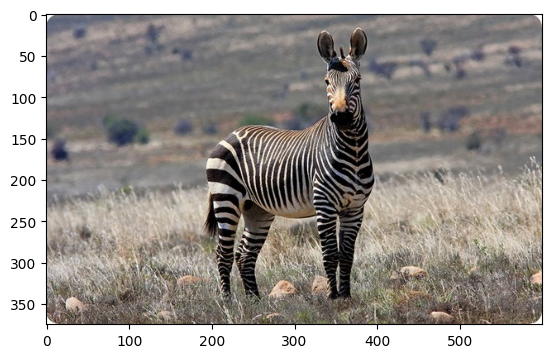

: 

In [59]:
plt.imshow(image)

**Правильно ли модель классифицировала ваше изображение?** (макс. 10 баллов)

Ваш ответ: модель верно классифицировала изображение

**Какая итоговая точность работы вашей модели на тестовой выборке?** (макс. 10 баллов)

Ваш ответ: Итоговая точность модели после дообучения - 92.48%

**Чем отличается прием извлечения признаков от дообучения?** (макс. 20 баллов)

Ваш ответ: извлечение признаков подразумевает собой полную "заморозку" предобученной модели. Меняется только полносвязная часть ("голова"), которая адаптируется под новую задачу. При дообучении параметры сверточных слоев модели размораживаются полностью или частично, что позволяет сильнее подстроить модель под конкретную задачу. Однако для применения дообучения нужно достаточное количество тренировочных данных, иначе есть риск получить модель качества ниже, чем она была изначально.